<a href="https://colab.research.google.com/github/costpetrides/FAIRMODE-WG5/blob/main/Python/XGBSF_O3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 29.4 MB/s eta 0:00:00


In [2]:
pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 43.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import netCDF4 as nc
import xgboost as xgb
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import BallTree
from tqdm import tqdm

# === Load CSV Data (Station Measurements) ===
csv_file_path = "baseO3nearest_grid.csv"
df = pd.read_csv(csv_file_path)

# Compute Bias (Observed - Modeled)
df["bias"] = df["SURF_ppb_O3"] - df["nearest_SURF_ppb_O3"]

# === Load NetCDF Data (Grid Model) ===
netcdf_path = "BaseCase_PERT_O3_YEARLY.nc"
dataset = nc.Dataset(netcdf_path, "r")

lon = dataset.variables["lon"][:]
lat = dataset.variables["lat"][:]
o3_modeled = dataset.variables["SURF_ppb_O3"][0, :, :]

# Convert Degrees to Radians for Haversine Distance
lon_rad = np.radians(lon)
lat_rad = np.radians(lat)

# === Create Meshgrid for Grid Points ===
lon_mesh, lat_mesh = np.meshgrid(lon_rad, lat_rad)
grid_points = np.column_stack([lat_mesh.ravel(), lon_mesh.ravel()])

# === Prepare Station Data (Convert to Radians) ===
station_points = np.column_stack([
    np.radians(df["nearest_grid_lat"].values),
    np.radians(df["nearest_grid_lon"].values)
])
station_o3 = df["nearest_SURF_ppb_O3"].values  # Modeled O₃ at stations
station_bias = df["bias"].values  # Observed bias

# === BallTree for Nearest Neighbor Search ===
tree = BallTree(station_points, metric="haversine")

# === Function: Compute Spatial Features ===
def compute_spatial_features(points, station_points, station_o3, station_bias, k=5):
    """Finds nearest k stations and computes mean, min, max, variance, and IDW-weighted O₃."""
    dists, idxs = tree.query(points, k=k)

    mean_o3 = np.mean(station_o3[idxs], axis=1)
    min_o3 = np.min(station_o3[idxs], axis=1)
    max_o3 = np.max(station_o3[idxs], axis=1)
    var_o3 = np.var(station_o3[idxs], axis=1)
    mean_bias = np.mean(station_bias[idxs], axis=1)

    weights = 1 / (dists + 1e-6)
    weights /= np.sum(weights, axis=1, keepdims=True)

    idw_o3 = np.sum(weights * station_o3[idxs], axis=1)

    return mean_o3, min_o3, max_o3, var_o3, idw_o3, mean_bias

# === Compute Spatial Features for Stations ===
mean_o3_s, min_o3_s, max_o3_s, var_o3_s, idw_o3_s, mean_bias_s = compute_spatial_features(
    station_points, station_points, station_o3, station_bias, k=5
)

# Construct Feature Matrix for XGBoost Training
X_train = np.column_stack([
    df["nearest_grid_lon"].values,
    df["nearest_grid_lat"].values,
    df["nearest_SURF_ppb_O3"].values,
    mean_o3_s, min_o3_s, max_o3_s, var_o3_s, idw_o3_s, mean_bias_s
])
y_train = station_bias

# === Compute Spatial Features for Grid Points ===
mean_o3_g, min_o3_g, max_o3_g, var_o3_g, idw_o3_g, mean_bias_g = compute_spatial_features(
    grid_points, station_points, station_o3, station_bias, k=5
)

# Construct Feature Matrix for XGBoost Prediction
X_grid = np.column_stack([
    np.degrees(grid_points[:, 1]),  # Convert back to degrees
    np.degrees(grid_points[:, 0]),
    o3_modeled.ravel(),
    mean_o3_g, min_o3_g, max_o3_g, var_o3_g, idw_o3_g, mean_bias_g
])

# === Hyperparameter Grid for XGBoost ===
param_grid = {
    "n_estimators": [100, 300],
    "max_depth": [10, 15],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "gamma": [0, 0.1, 0.2],
}

param_list = list(ParameterGrid(param_grid))

# === Grid Search with RMSE, MAE, R² Calculation ===
best_rmse = float("inf")
best_params = None
results = []

print("\nPerforming Hyperparameter Optimization (XGBoost)...")

for params in tqdm(param_list, desc="Grid Search Progress", unit="combination"):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_rmses, fold_maes, fold_r2s = [], [], []

    for train_idx, test_idx in kf.split(X_train):
        X_tr, X_te = X_train[train_idx], X_train[test_idx]
        y_tr, y_te = y_train[train_idx], y_train[test_idx]

        model = xgb.XGBRegressor(**params, random_state=42, n_jobs=-1)
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_te)

        fold_rmse = np.sqrt(mean_squared_error(y_te, y_pred))
        fold_mae = mean_absolute_error(y_te, y_pred)
        fold_r2 = r2_score(y_te, y_pred)

        fold_rmses.append(fold_rmse)
        fold_maes.append(fold_mae)
        fold_r2s.append(fold_r2)

    mean_rmse = np.mean(fold_rmses)

    results.append((params, mean_rmse))

    if mean_rmse < best_rmse:
        best_rmse = mean_rmse
        best_params = params

print(f"\n Best Parameters Found: {best_params}")
print(f"Best Model Score (RMSE): {best_rmse:.4f}")

# Train Final XGBoost Model with Best Parameters
best_model = xgb.XGBRegressor(**best_params, random_state=42, n_jobs=-1)
best_model.fit(X_train, y_train)

# === Predict Bias on the Grid ===
print("\n Predicting Bias on the Grid with Optimized XGBoost...")
interpolated_bias_xgb = best_model.predict(X_grid).reshape(o3_modeled.shape)

# === Save Bias Correction to NetCDF ===
xgb_bias_netcdf_path = "BaseCase_O3_Y_XGB.nc"

with nc.Dataset(xgb_bias_netcdf_path, "w", format="NETCDF4") as bias_nc:
    bias_nc.createDimension("lat", lat.shape[0])
    bias_nc.createDimension("lon", lon.shape[0])

    lat_var = bias_nc.createVariable("lat", "f4", ("lat",))
    lon_var = bias_nc.createVariable("lon", "f4", ("lon",))
    bias_var = bias_nc.createVariable("Interpolated_Bias_XGB", "f4", ("lat", "lon"))

    lat_var[:] = lat
    lon_var[:] = lon
    bias_var[:, :] = interpolated_bias_xgb

print(f"\n XGBoost Bias Interpolation Saved: {xgb_bias_netcdf_path}")


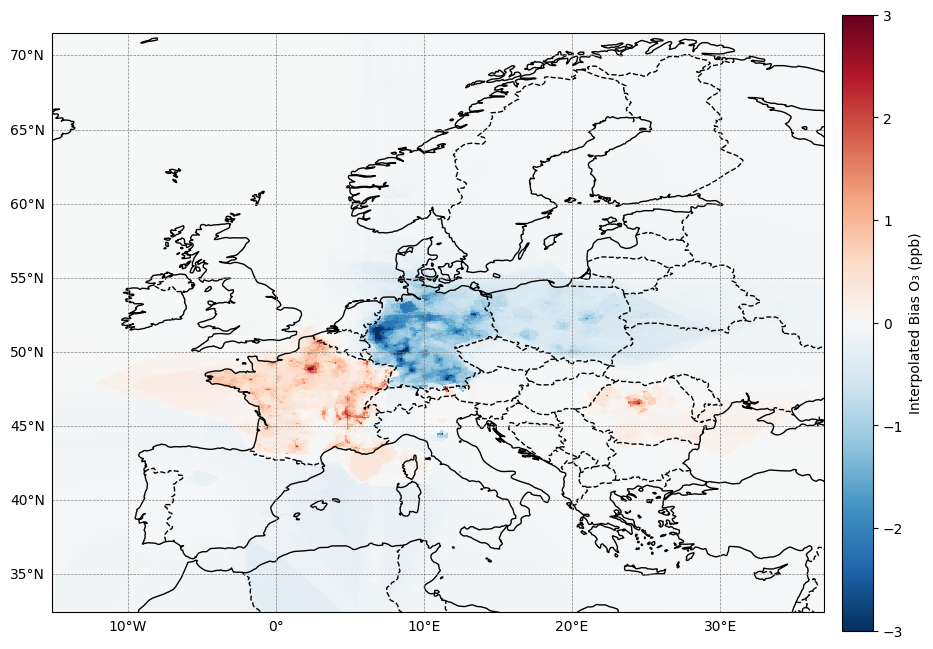

In [9]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# === Load the Interpolated Bias NetCDF File ===
bias_netcdf_path = "BaseCase_O3_Y_XGB.nc"  # Updated file name
ds_bias = xr.open_dataset(bias_netcdf_path)

# Extract interpolated bias (residuals)
interpolated_bias = ds_bias["Interpolated_Bias_XGB"].squeeze().values

# Extract coordinates
lon = ds_bias["lon"].values
lat = ds_bias["lat"].values

# === Define Plot Limits (Adjust if needed) ===
cbar_min = -3  # Minimum bias value for color scale (adjust if needed)
cbar_max = 3 # Maximum bias value for color scale (adjust if needed)

# Create a plot with Cartopy
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the interpolated bias
im = ax.pcolormesh(lon, lat, interpolated_bias, transform=ccrs.PlateCarree(), cmap="RdBu_r", vmin=cbar_min, vmax=cbar_max, shading='auto')

# Add colorbar
cbar = plt.colorbar(im, orientation="vertical", pad=0.02)
cbar.set_label("Interpolated Bias O₃ (ppb)")

# Add country borders and coastlines
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Add gridlines and labels for longitude and latitude
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Remove top labels
gl.right_labels = False  # Remove right-side labels

# Set title and labels
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

# Close dataset
ds_bias.close()

In [10]:
import netCDF4 as nc
import numpy as np

# === Define File Paths ===
original_nc_path = "BaseCase_PERT_O3_YEARLY.nc"  # Original modeled O₃
bias_nc_path = "BaseCase_O3_Y_XGB.nc"  # Interpolated bias NetCDF
corrected_nc_path = "BaseCase_Corrected_O3_Y_XGB.nc"  # Output corrected NetCDF

# === Load the Original Modeled O₃ NetCDF ===
with nc.Dataset(original_nc_path, "r") as original_nc, nc.Dataset(bias_nc_path, "r") as bias_nc:

    # Load model coordinates and data
    lon = original_nc.variables["lon"][:]
    lat = original_nc.variables["lat"][:]
    time = original_nc.variables["time"][:]
    o3_original = original_nc.variables["SURF_ppb_O3"][:]

    # Load the interpolated bias
    interpolated_bias = bias_nc.variables["Interpolated_Bias_XGB"][:]

    # === Compute the Unbiased O₃ ===
    o3_corrected = o3_original + interpolated_bias  # Apply bias correction

    # === Save the Corrected O₃ to a New NetCDF File ===
    with nc.Dataset(corrected_nc_path, "w", format="NETCDF4") as new_nc:

        # Create dimensions
        new_nc.createDimension("time", None)
        new_nc.createDimension("lat", lat.shape[0])
        new_nc.createDimension("lon", lon.shape[0])

        # Create variables
        time_var = new_nc.createVariable("time", "f4", ("time",))
        lat_var = new_nc.createVariable("lat", "f4", ("lat",))
        lon_var = new_nc.createVariable("lon", "f4", ("lon",))
        o3_var = new_nc.createVariable("SURF_ppb_O3_corrected", "f4", ("time", "lat", "lon"), fill_value=-9999.0)

        # Copy attributes from the original O₃ variable
        o3_var.setncatts(original_nc.variables["SURF_ppb_O3"].__dict__)

        # Save data
        time_var[:] = time
        lat_var[:] = lat
        lon_var[:] = lon
        o3_var[:] = o3_corrected  # Store corrected O₃

print(" Bias correction completed successfully!")
print(" Corrected O₃ NetCDF file saved as:", corrected_nc_path)


 Bias correction completed successfully!
 Corrected O₃ NetCDF file saved as: BaseCase_Corrected_O3_Y_XGB.nc


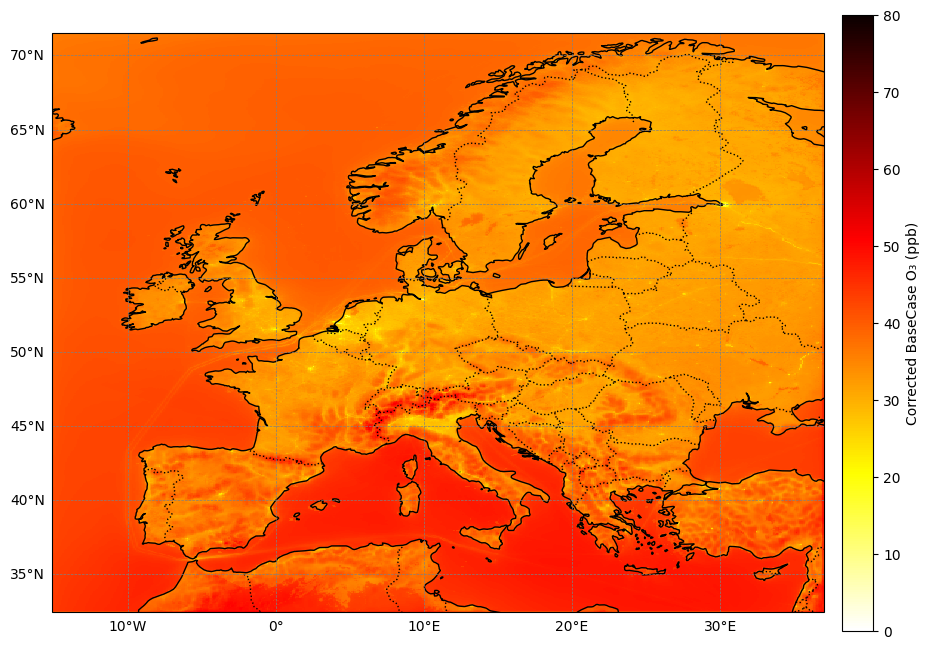

In [11]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import numpy as np

# === Load the Corrected O₃ NetCDF File ===
corrected_netcdf_path = "BaseCase_Corrected_O3_Y_XGB.nc"
ds_corrected = xr.open_dataset(corrected_netcdf_path)

# Extract corrected O₃ values
corrected_o3 = ds_corrected["SURF_ppb_O3_corrected"].squeeze().values

# Extract coordinates
lon = ds_corrected["lon"].values
lat = ds_corrected["lat"].values

# Create a 2D meshgrid for lon & lat
Lon, Lat = np.meshgrid(lon, lat)

# === Define Logarithmic Scale for Color Normalization ===
norm = mcolors.Normalize(0, 80)  # Log scale between 1 and max value (adjust if needed)

# Create a figure with a map projection
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the O₃ concentration using pcolormesh with logarithmic scaling
mesh = ax.pcolormesh(Lon, Lat, corrected_o3, cmap='hot_r', shading='auto', transform=ccrs.PlateCarree(), norm=norm)

# Add a colorbar with logarithmic scaling
cbar = plt.colorbar(mesh, orientation="vertical", pad=0.02)
cbar.set_label("Corrected BaseCase O₃ (ppb)")

# Add coastlines and borders for context
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add gridlines and labels for longitude and latitude
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Remove top labels
gl.right_labels = False  # Remove right-side labels

# Set title and labels
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

# Close dataset
ds_corrected.close()

In [12]:
import netCDF4 as nc
import numpy as np

# === Define File Paths ===
perturbed_scenario_nc_path = "SCEN_PERT_O3_YEARLY.nc"  # Perturbed scenario NetCDF
interpolated_residual_nc_path = "BaseCase_O3_Y_XGB.nc"  # Interpolated residuals NetCDF
base_corrected_nc_path = "BaseCase_Corrected_O3_Y_XGB.nc"  # Base case corrected NetCDF
corrected_scenario_nc_path = "Scenario_Corrected_O3_Y_XGB.nc"  # Output corrected scenario NetCDF

# === Load NetCDF Data ===
with nc.Dataset(perturbed_scenario_nc_path, "r") as pert_nc, \
     nc.Dataset(interpolated_residual_nc_path, "r") as res_nc, \
     nc.Dataset(base_corrected_nc_path, "r") as base_nc:

    # Load variables
    lon = pert_nc.variables["lon"][:]
    lat = pert_nc.variables["lat"][:]
    time = pert_nc.variables["time"][:]
    scenario_perturb = pert_nc.variables["SURF_ppb_O3"][:]

    interpolated_residual = res_nc.variables["Interpolated_Bias_XGB"][:]
    base_corrected = base_nc.variables["SURF_ppb_O3_corrected"][:]

    # === Compute the Unbiased Scenario ===
    scenario_corrected = scenario_perturb * (1 + interpolated_residual / base_corrected)

    # === Save the Corrected Scenario to a New NetCDF File ===
    with nc.Dataset(corrected_scenario_nc_path, "w", format="NETCDF4") as new_nc:

        # Create dimensions
        new_nc.createDimension("time", None)
        new_nc.createDimension("lat", lat.shape[0])
        new_nc.createDimension("lon", lon.shape[0])

        # Create variables
        time_var = new_nc.createVariable("time", "f4", ("time",))
        lat_var = new_nc.createVariable("lat", "f4", ("lat",))
        lon_var = new_nc.createVariable("lon", "f4", ("lon",))
        scenario_var = new_nc.createVariable("SURF_ppb_O3_corrected", "f4", ("time", "lat", "lon"), fill_value=-9999.0)

        # Copy attributes from the original variable
        scenario_var.setncatts(pert_nc.variables["SURF_ppb_O3"].__dict__)

        # Save data
        time_var[:] = time
        lat_var[:] = lat
        lon_var[:] = lon
        scenario_var[:] = scenario_corrected  # Store corrected scenario

print(" Scenario Bias Correction Completed Successfully!")
print(" Corrected O₃ Scenario NetCDF file saved as:", corrected_scenario_nc_path)


 Scenario Bias Correction Completed Successfully!
 Corrected O₃ Scenario NetCDF file saved as: Scenario_Corrected_O3_Y_XGB.nc


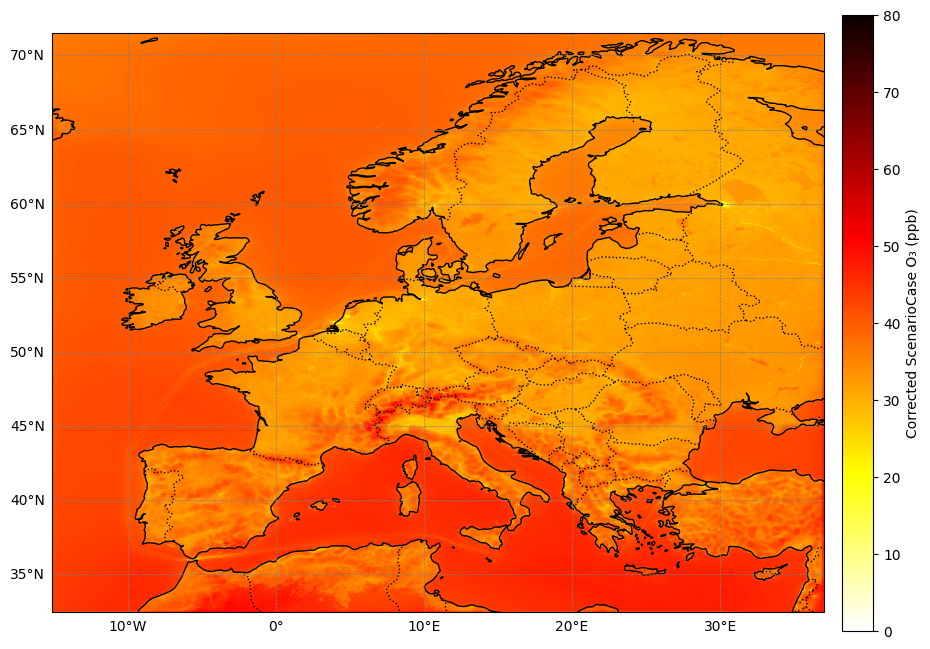

In [14]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import numpy as np

# === Load the Corrected Scenario O₃ NetCDF File ===
corrected_netcdf_path = "Scenario_Corrected_O3_Y_XGB.nc"  # Adjust path if needed
ds_corrected = xr.open_dataset(corrected_netcdf_path)

# Extract corrected O₃ scenario values
corrected_o3 = ds_corrected["SURF_ppb_O3_corrected"].squeeze().values

# Extract coordinates
lon = ds_corrected["lon"].values
lat = ds_corrected["lat"].values

# Create a 2D meshgrid for lon & lat
Lon, Lat = np.meshgrid(lon, lat)

# === Define Logarithmic Scale for Color Normalization ===
norm = mcolors.Normalize(0, 80)  # Adjust scale if needed

# Create a figure with a map projection
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot the corrected O₃ scenario using pcolormesh with logarithmic scaling
mesh = ax.pcolormesh(Lon, Lat, corrected_o3, cmap='hot_r', shading='auto', transform=ccrs.PlateCarree(), norm=norm)

# Add a colorbar with logarithmic scaling
cbar = plt.colorbar(mesh, orientation="vertical", pad=0.02)
cbar.set_label("Corrected ScenarioCase O₃ (ppb)")

# Add coastlines and borders for context
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":")

# Add gridlines and labels for longitude and latitude
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Remove top labels
gl.right_labels = False  # Remove right-side labels

# Set title and labels
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

# Close dataset
ds_corrected.close()